**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi

!ls /content/drive/MyDrive/data

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found
192-168-5-106_2025-10-08-09-00-49-AM_ISPM_RolltoRoll_GEN5_ISPM_PH3_Reference_Both_Edge_Labels
192-168-5-106_2025-10-08-09-16-10-AM_ISPM_RolltoRoll_GEN5_ISPM_PH3_Increase_Both_Edge_Labels
192-168-5-106_2025-10-08-10-55-35-AM_ISPM_RolltoRoll_GEN5_ISPM_PH3_Decrease_Both_Edge_Labels
2025-05-26-03-00-51-PM_Gradually_Lowering_Pressure_0dot4mBar_Steps
2025-05-27-03-22-58-PM_Gradually_Increasing_Pressure_0dot4mBar_Steps_ISPM_PH4
fit
preprocessed
ringdown


Loaded 1_lowering: n=120313 | counts={'Jetting': 117375, 'NonJetting': 2938}
Balanced train: n=4874 | counts={'Jetting': 2437, 'NonJetting': 2437}
Balanced test : n=1002 | counts={'NonJetting': 501, 'Jetting': 501}
[1_lowering] BALANCED held-out test | n=1002 | counts={'NonJetting': 501, 'Jetting': 501} | Acc=0.999 Prec=1.000 Rec=0.998 F1=0.999


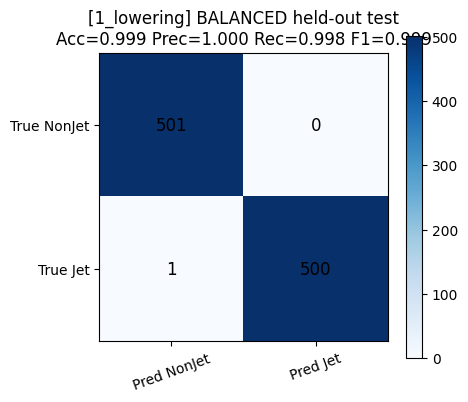


--- FULL-DATASET EVAL ---
[1_lowering] FULL minus TRAIN SIGNALS | n=115439 | counts={'Jetting': 114938, 'NonJetting': 501} | Acc=0.997 Prec=1.000 Rec=0.997 F1=0.999


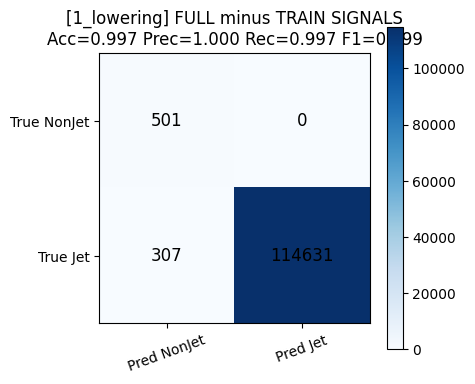

[2_lowering] FULL (entire dataset) | n=119976 | counts={'Jetting': 116837, 'NonJetting': 3139} | Acc=0.998 Prec=1.000 Rec=0.998 F1=0.999


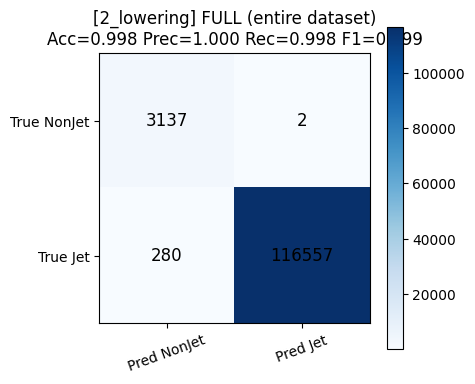

[1_increasing] FULL (entire dataset) | n=13679 | counts={'Jetting': 12506, 'NonJetting': 1173} | Acc=0.955 Prec=1.000 Rec=0.951 F1=0.975


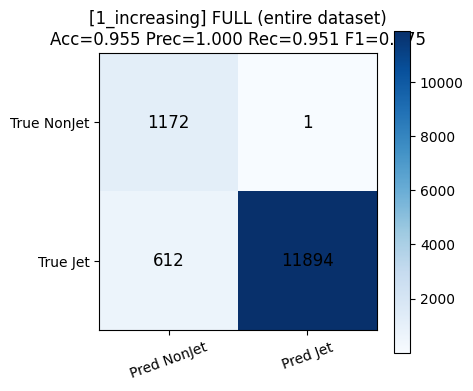

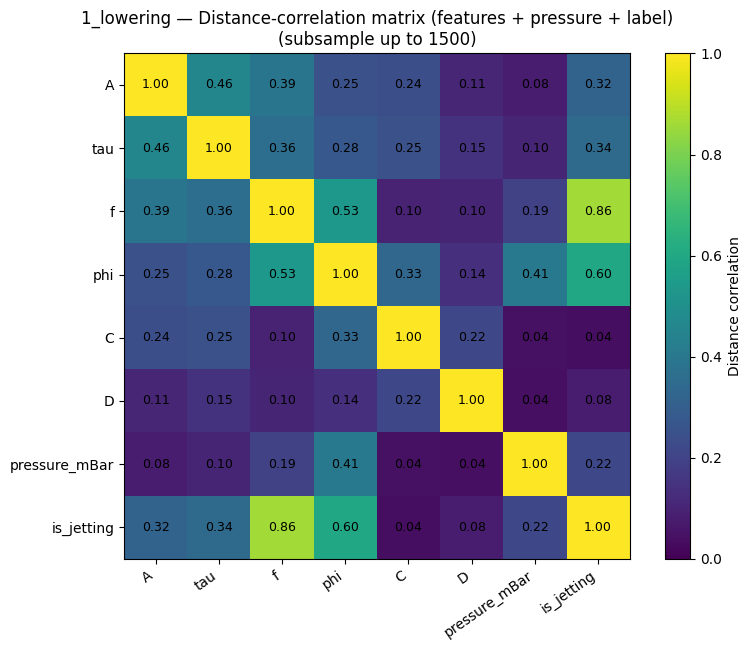

In [ ]:
# ==== HGBC-only binary classifier (Jetting vs Non-jetting) ====
# Train: 1_lowering (GroupShuffleSplit by nozzle, test_size=0.2, random_state=42)
# Test:
#   (A) balanced held-out test (same idea as before)
#   (B) FULL datasets:
#       - 2_lowering: evaluate on the ENTIRE dataset
#       - 1_increasing: evaluate on the ENTIRE dataset
#       - 1_lowering: evaluate on ENTIRE dataset EXCEPT the exact (nozzle_id, pressure_idx) signals used for training
# Keep only: confusion matrix plot + (acc, prec, rec, f1) + distance-correlation matrix plot

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ---------------- Config ----------------
FIT_DIR   = "/content/drive/MyDrive/data/fit"

TRAIN_DS  = "1_lowering"
TEST_DS   = ["2_lowering", "1_increasing"]  # evaluated fully
ALL_EVAL  = [TRAIN_DS] + TEST_DS

FEATS = ["A", "tau", "f", "phi", "C", "D"]

NONJET_VARIANTS = {"non-jetting", "non jetting", "nonjetting", "non_jetting"}

RANDOM_STATE_SPLIT = 42
RANDOM_STATE_BAL_TRAIN = 42
RANDOM_STATE_BAL_TEST  = 123

# Distance correlation is O(n^2) memory/time -> keep this small to avoid crashing
DCOR_MAX_N = 1500
DCOR_RANDOM_STATE = 42

# ---------------- Helpers ----------------
def dataset_to_paths(dataset_key: str):
    rep = int(dataset_key.split("_")[0])
    var = dataset_key.split("_", 1)[1]
    merged_fp = os.path.join(
        FIT_DIR,
        f"merged_rep_{rep}_{var}_bankcorrected_params6_Q_rmse_nrmse_labels.npz"
    )
    return rep, var, merged_fp

def canonical_binary_label(raw) -> str:
    """Return 'Jetting' / 'NonJetting' / '' (ignored)."""
    s = str(raw).strip()
    if s == "" or s.lower() in ("nan", "none"):
        return ""
    low = s.lower()
    if low == "jetting":
        return "Jetting"
    if low in NONJET_VARIANTS:
        return "NonJetting"
    return ""  # ignore Deviated / Intermittent / Other / etc.

def load_df_binary(dataset_key: str) -> pd.DataFrame:
    """Load merged NPZ and return a tidy df with only Jetting/NonJetting rows."""
    rep, var, merged_fp = dataset_to_paths(dataset_key)
    if not os.path.exists(merged_fp):
        raise FileNotFoundError(f"Missing merged NPZ with labels:\n  {merged_fp}")

    m = np.load(merged_fp, allow_pickle=True)
    params6    = m["params6_all"]                 # (N,P,6)
    pressures  = m["pressures"].astype(float)     # (P,)
    nozzles    = m["nozzles"].astype(object)      # (N,)
    labels_raw = m["labels"]                      # (N,P)

    N, P, _ = params6.shape

    ii, jj = np.meshgrid(np.arange(N), np.arange(P), indexing="ij")
    labels_flat = labels_raw.reshape(-1)

    df = pd.DataFrame({
        "dataset":      dataset_key,
        "nozzle_idx":   ii.ravel().astype(int),
        "nozzle_id":    nozzles[ii.ravel()],
        "pressure_idx": jj.ravel().astype(int),
        "pressure_mBar": pressures[jj].ravel().astype(float),
        "A":   params6[:, :, 0].ravel(),
        "tau": params6[:, :, 1].ravel(),
        "f":   params6[:, :, 2].ravel(),
        "phi": params6[:, :, 3].ravel(),
        "C":   params6[:, :, 4].ravel(),
        "D":   params6[:, :, 5].ravel(),
        "LabelRaw": labels_flat,
    })

    df["LabelBin"] = df["LabelRaw"].map(canonical_binary_label)
    df = df[df["LabelBin"].isin(["Jetting", "NonJetting"])].copy()

    # y: 1=Jetting, 0=NonJetting
    df["is_jetting"] = (df["LabelBin"] == "Jetting").astype(int)

    # Drop non-finite feature rows
    Xv = df[FEATS].to_numpy(dtype=float, copy=False)
    ok = np.isfinite(Xv).all(axis=1)
    df = df.loc[ok].reset_index(drop=True)

    # normalize nozzle_id to string for stable keying
    df["nozzle_id"] = df["nozzle_id"].astype(str)

    return df

def balance_keep_all_nonjet(df_part: pd.DataFrame, random_state: int) -> pd.DataFrame:
    """Keep ALL NonJetting (y=0) and subsample Jetting (y=1) to match count."""
    df0 = df_part[df_part["is_jetting"] == 0]
    df1 = df_part[df_part["is_jetting"] == 1]
    n0, n1 = len(df0), len(df1)

    if n0 == 0 or n1 == 0:
        return df_part.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    if n1 > n0:
        df1s = df1.sample(n=n0, random_state=random_state)
    else:
        df1s = df1

    out = pd.concat([df0, df1s], axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return out

def plot_confmat(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 0=NonJetting, 1=Jetting
    plt.figure(figsize=(4.8, 4.2))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks([0, 1], ["Pred NonJet", "Pred Jet"], rotation=20)
    plt.yticks([0, 1], ["True NonJet", "True Jet"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center", fontsize=12)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm

def eval_and_report(model, df_eval: pd.DataFrame, tag: str, show_plot=True):
    X = df_eval[FEATS]
    y = df_eval["is_jetting"].astype(int).to_numpy()

    y_pred = model.predict(X)

    acc  = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec  = recall_score(y, y_pred, zero_division=0)
    f1   = f1_score(y, y_pred, zero_division=0)

    counts = df_eval["LabelBin"].value_counts().to_dict()
    print(f"{tag} | n={len(df_eval)} | counts={counts} | Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

    if show_plot:
        plot_confmat(y, y_pred, title=f"{tag}\nAcc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1}

# ---------------- Distance correlation (small n only) ----------------
def distance_correlation(x, y):
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    n = x.shape[0]
    if y.shape[0] != n:
        raise ValueError("x and y must have same length")

    a = np.sqrt(((x[:, None, :] - x[None, :, :]) ** 2).sum(axis=2))
    b = np.sqrt(((y[:, None, :] - y[None, :, :]) ** 2).sum(axis=2))

    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / (n ** 2)
    dcov2_xx = (A * A).sum() / (n ** 2)
    dcov2_yy = (B * B).sum() / (n ** 2)

    if dcov2_xx == 0 or dcov2_yy == 0:
        return 0.0
    return np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx * dcov2_yy))

def plot_distance_corr_matrix(df_for_dcor: pd.DataFrame, title: str):
    cols = FEATS + ["pressure_mBar", "is_jetting"]
    df_sub = df_for_dcor[cols].dropna()

    if len(df_sub) > DCOR_MAX_N:
        df_sub = df_sub.sample(n=DCOR_MAX_N, random_state=DCOR_RANDOM_STATE)

    data = df_sub.to_numpy()
    names = cols
    k = len(names)
    mat = np.zeros((k, k), dtype=float)

    for i in range(k):
        mat[i, i] = 1.0
        for j in range(i + 1, k):
            mat[i, j] = distance_correlation(data[:, i], data[:, j])
            mat[j, i] = mat[i, j]

    plt.figure(figsize=(8.4, 6.6))
    plt.imshow(mat, vmin=0, vmax=1)
    plt.colorbar(label="Distance correlation")
    plt.xticks(range(k), names, rotation=35, ha="right")
    plt.yticks(range(k), names)
    for i in range(k):
        for j in range(k):
            plt.text(j, i, f"{mat[i,j]:.2f}", ha="center", va="center", fontsize=9)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------------- 1) Load training dataset + split (same split style as before) ----------------
df_train_ds = load_df_binary(TRAIN_DS)

print(f"Loaded {TRAIN_DS}: n={len(df_train_ds)} | counts={df_train_ds['LabelBin'].value_counts().to_dict()}")

groups = df_train_ds["nozzle_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE_SPLIT)
train_idx, test_idx = next(gss.split(df_train_ds[FEATS], df_train_ds["is_jetting"].values, groups=groups))

df_train_full = df_train_ds.iloc[train_idx].copy()
df_test_full  = df_train_ds.iloc[test_idx].copy()

# ---------------- 2) Balance train/test (like before) ----------------
df_train_bal = balance_keep_all_nonjet(df_train_full, random_state=RANDOM_STATE_BAL_TRAIN)
df_test_bal  = balance_keep_all_nonjet(df_test_full,  random_state=RANDOM_STATE_BAL_TEST)

print(f"Balanced train: n={len(df_train_bal)} | counts={df_train_bal['LabelBin'].value_counts().to_dict()}")
print(f"Balanced test : n={len(df_test_bal)} | counts={df_test_bal['LabelBin'].value_counts().to_dict()}")

# training-signal keys to exclude later ONLY for 1_lowering full eval
train_signal_keys = pd.MultiIndex.from_frame(
    df_train_bal[["nozzle_id", "pressure_idx"]].astype({"nozzle_id": str, "pressure_idx": int})
)

# ---------------- 3) Train HGBC only ----------------
hgbc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        max_bins=255
    ))
])

hgbc.fit(df_train_bal[FEATS], df_train_bal["is_jetting"].astype(int).to_numpy())

# ---------------- 4) Test (A) balanced held-out test (should match prior results) ----------------
eval_and_report(hgbc, df_test_bal, tag=f"[{TRAIN_DS}] BALANCED held-out test", show_plot=True)

# ---------------- 5) Test (B) FULL datasets ----------------
print("\n--- FULL-DATASET EVAL ---")
for ds in ALL_EVAL:
    df_ds = load_df_binary(ds)

    if ds == TRAIN_DS:
        # exclude only the exact (nozzle_id, pressure_idx) signals used for training
        eval_keys = pd.MultiIndex.from_frame(
            df_ds[["nozzle_id", "pressure_idx"]].astype({"nozzle_id": str, "pressure_idx": int})
        )
        keep_mask = ~eval_keys.isin(train_signal_keys)
        df_eval = df_ds.loc[keep_mask].copy()
        tag = f"[{ds}] FULL minus TRAIN SIGNALS"
    else:
        # IMPORTANT: evaluate ENTIRE dataset (no exclusion) since it's not used for training
        df_eval = df_ds
        tag = f"[{ds}] FULL (entire dataset)"

    if len(df_eval) == 0:
        print(f"{tag} | n=0 (nothing to evaluate).")
        continue

    eval_and_report(hgbc, df_eval, tag=tag, show_plot=True)

# ---------------- 6) Distance correlation matrix (train dataset only) ----------------
plot_distance_corr_matrix(
    df_train_ds,
    title=f"{TRAIN_DS} — Distance-correlation matrix (features + pressure + label)\n(subsample up to {DCOR_MAX_N})"
)
